In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import csv
from collections import Counter

LOADING THE DATASET

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d "maciejgronczynski/biggest-genderface-recognition-dataset"

 98% 428M/439M [00:02<00:00, 184MB/s]
100% 439M/439M [00:02<00:00, 186MB/s]


In [ ]:
!unzip "/content/biggest-genderface-recognition-dataset.zip"

LET'S SEE SOME IMAGES

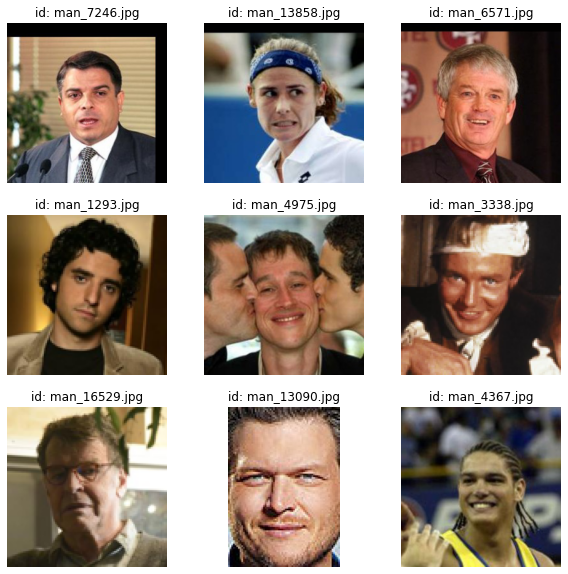

In [ ]:
man_folder="faces/man"
some_images=[]
names=[]
i=0
for filename in os.listdir(man_folder):
  i+=1
  if i==10:
    break
  im=Image.open(os.path.join(man_folder,filename))
  img=np.array(im)
  if img is not None:
      some_images.append(img)
      names.append(filename)

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(some_images[i])
    plt.title(f"id: {names[i]}")
    plt.axis("off")

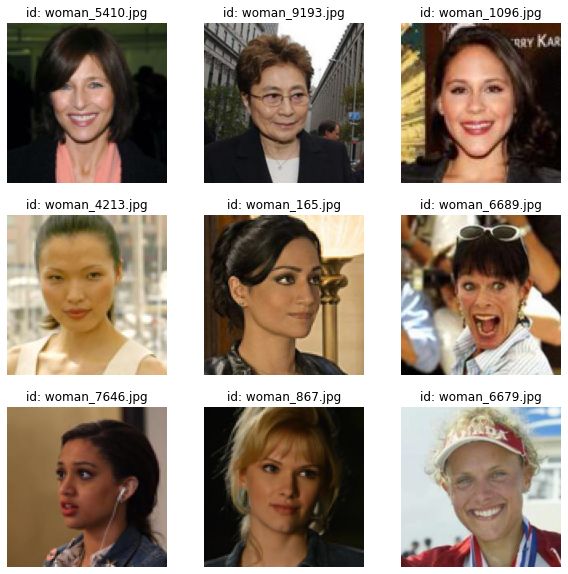

In [ ]:
woman_folder="faces/woman"
some_images=[]
names=[]
i=0
for filename in os.listdir(woman_folder):
  i+=1
  if i==10:
    break
  im=Image.open(os.path.join(woman_folder,filename))
  img=np.array(im)
  if img is not None:
      some_images.append(img)
      names.append(filename)

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(some_images[i])
    plt.title(f"id: {names[i]}")
    plt.axis("off")

In [ ]:
import os
male_id=[]
for f in os.listdir("/content/faces/man/"):
  male_id.append(f)

female_id=[]
for f in os.listdir("/content/faces/woman/"):
  female_id.append(f)
print(f"number of male images: {len(male_id)}")
print(f"number of female images: {len(female_id)}")
print(f"total images: {len(male_id)+len(female_id)}")

number of male images: 17678
number of female images: 9489
total images: 27167


IMAGE PREPROCESSING

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(validation_split=0.2,
                           preprocessing_function=keras.applications.vgg16.preprocess_input)

train_generator=datagen.flow_from_directory("/content/faces/",
                                            target_size=(224,224),
                                            color_mode='rgb', 
                                            batch_size=64,
                                            class_mode='binary',
                                            subset='training')

test_generator=datagen.flow_from_directory("/content/faces/",
                                            target_size=(224,224), 
                                            color_mode='rgb', 
                                            batch_size=64,
                                            class_mode='binary',
                                            subset='validation')

print(train_generator.class_indices)

Found 21735 images belonging to 2 classes.
Found 5432 images belonging to 2 classes.
{'man': 0, 'woman': 1}


LET'S DEFINE THE CLASS WEIGHTS

In [ ]:
total=len(male_id)+len(female_id)

class_weight={0:total/(2*len(male_id)),1:total/(2*len(female_id))}
print(class_weight)

{0: 0.7683844326281254, 1: 1.43149963115186}


MODEL DEFINITION - WE USE THE VGG16 PRETRAINED MODEL

In [ ]:
base_model=keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))
flat=keras.layers.Flatten(name='flatten')(base_model.output)
dense1=keras.layers.Dense(512,activation='relu',name='dense1')(flat)
drop1=keras.layers.Dropout(0.25,name='dropout1')(dense1)
dense2=keras.layers.Dense(256,activation='relu',name='dense2')(drop1)
drop2=keras.layers.Dropout(0.25,name='dropout2')(dense2)
dense3=keras.layers.Dense(256,activation='relu',name='dense3')(drop2)
drop3=keras.layers.Dropout(0.3,name='dropout3')(dense3)
output=keras.layers.Dense(1,activation='sigmoid',name='output')(drop3)

model=keras.Model(inputs=base_model.input,outputs=output)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

TRAINING THE MODEL (CNN LAYERS ARE FREEZED)

In [ ]:
for layer in base_model.layers[:]:
  layer.trainable= False

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',
                                                                   tf.keras.metrics.Precision(),
                                                                   tf.keras.metrics.Recall()])

checkpoint_cb=keras.callbacks.ModelCheckpoint("gender_vgg16model.h5")
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit(train_generator,validation_data=test_generator, class_weight=class_weight,
                  epochs=15,callbacks=[checkpoint_cb,early_stopping_cb])


Epoch 1/15
340/340 [==============================] - 141s 400ms/step - loss: 0.8674 - accuracy: 0.8440 - val_loss: 0.2922 - val_accuracy: 0.8975
Epoch 2/15
340/340 [==============================] - 135s 397ms/step - loss: 0.2448 - accuracy: 0.9140 - val_loss: 0.2671 - val_accuracy: 0.9092
Epoch 3/15
340/340 [==============================] - 136s 401ms/step - loss: 0.1723 - accuracy: 0.9406 - val_loss: 0.2520 - val_accuracy: 0.9179
Epoch 4/15
340/340 [==============================] - 136s 401ms/step - loss: 0.1177 - accuracy: 0.9585 - val_loss: 0.2961 - val_accuracy: 0.9142
Epoch 5/15
340/340 [==============================] - 136s 401ms/step - loss: 0.0846 - accuracy: 0.9712 - val_loss: 0.3107 - val_accuracy: 0.9173
Epoch 6/15
340/340 [==============================] - 136s 401ms/step - loss: 0.0650 - accuracy: 0.9802 - val_loss: 0.3113 - val_accuracy: 0.9212


CONTINUE THE TRAINING (UNFREEZE THE CNN LAYERS AND LOWER THE LEARNING RATE TO AVOID DAMAGING THE CNN WEIGHTS)

In [ ]:
for layer in base_model.layers[:]:
  layer.trainable= True

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',
                                                                   tf.keras.metrics.Precision(),
                                                                   tf.keras.metrics.Recall()])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit(train_generator,validation_data=test_generator, class_weight=class_weight,
                  epochs=15,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/15
340/340 [==============================] - 327s 939ms/step - loss: 0.3385 - accuracy: 0.8640 - val_loss: 0.1968 - val_accuracy: 0.9293
Epoch 2/15
340/340 [==============================] - 320s 940ms/step - loss: 0.1567 - accuracy: 0.9422 - val_loss: 0.1758 - val_accuracy: 0.9439
Epoch 3/15
340/340 [==============================] - 319s 938ms/step - loss: 0.1090 - accuracy: 0.9637 - val_loss: 0.1367 - val_accuracy: 0.9542
Epoch 4/15
340/340 [==============================] - 319s 937ms/step - loss: 0.0890 - accuracy: 0.9700 - val_loss: 0.1866 - val_accuracy: 0.9510
Epoch 5/15
340/340 [==============================] - 318s 936ms/step - loss: 0.0730 - accuracy: 0.9761 - val_loss: 0.1656 - val_accuracy: 0.9461
Epoch 6/15
340/340 [==============================] - 318s 936ms/step - loss: 0.0642 - accuracy: 0.9785 - val_loss: 0.2399 - val_accuracy: 0.9170


CONFUSION MATRIX

Found 5432 images belonging to 2 classes.


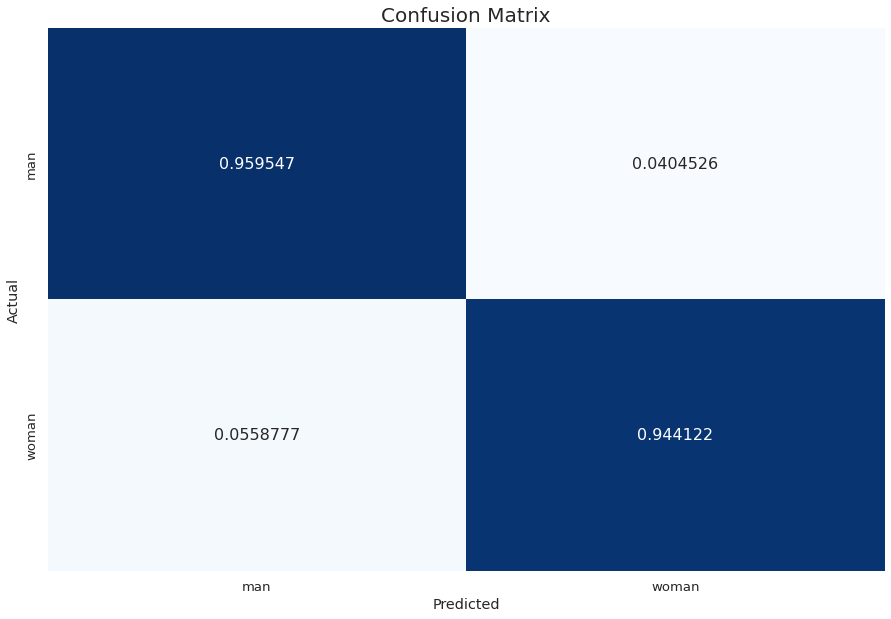

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_generator=datagen.flow_from_directory("/content/faces/",
                                            target_size=(224,224), 
                                            color_mode='rgb', 
                                            batch_size=64,
                                            class_mode='binary',
                                            shuffle=False,
                                            subset='validation')

preds = model.predict(test_generator)
y_pred = np.where(preds > 0.5, 1, 0)
y_test=test_generator.classes

CLASS_LABELS  = ['man','woman']

cm_data = confusion_matrix(y_test, y_pred,normalize='true')
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

LET'S PREDICT AN IMAGE WE WANT

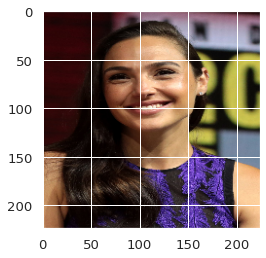

In [ ]:
#load the image we want to classify
img = cv2.imread('gal_gadot.png')
img_res=cv2.resize(img,dsize=(224,224))
rgb=cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(rgb)

In [ ]:
input_cnn=keras.applications.vgg16.preprocess_input(rgb)
input_cnn=input_cnn.reshape(1,224,224,3)

y_pred=model.predict(input_cnn)[0][0]
label="woman" if y_pred>0.5 else "man"
print(f"the above image is a {label} ({round(y_pred*100,2)}%)")

the above image is a woman (99.54%)
